In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from thermo_property.thermo_properties import Get_ThermoProperties, Get_MachAltitude

from aero_property.PressureCoeff import Get_Pressure_Coeff
from aero_property.LiftCoeff import Get_LiftCoeff
from aero_property.DragCoeff import Reynolds, Get_Frot_Coeff, Get_Wall_Constraint, Get_Drag_Coeff, Get_Total_Drag

from thermo_property.LocalThermoProperties import Get_Local_Params
from profil_config.modelisation import AoA_Effect, Get_Local_Velocity, curv

from CAO_management.STL_to_CSV import Get_CSV
from CAO_management.TriangleAndSegment import TransformCSV
from CAO_management.ShowFigure import ShowLaunchersFigure

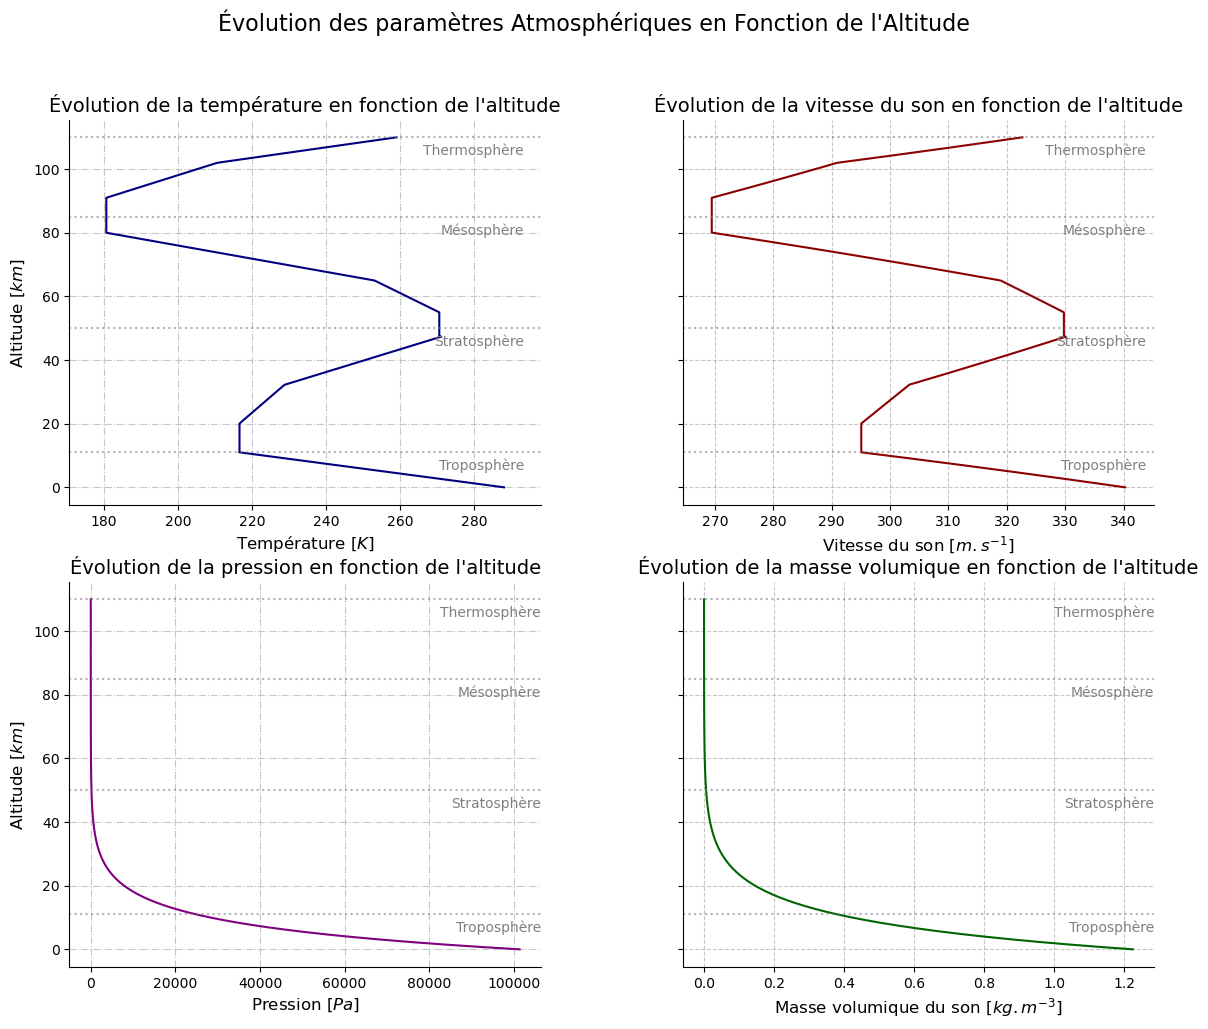

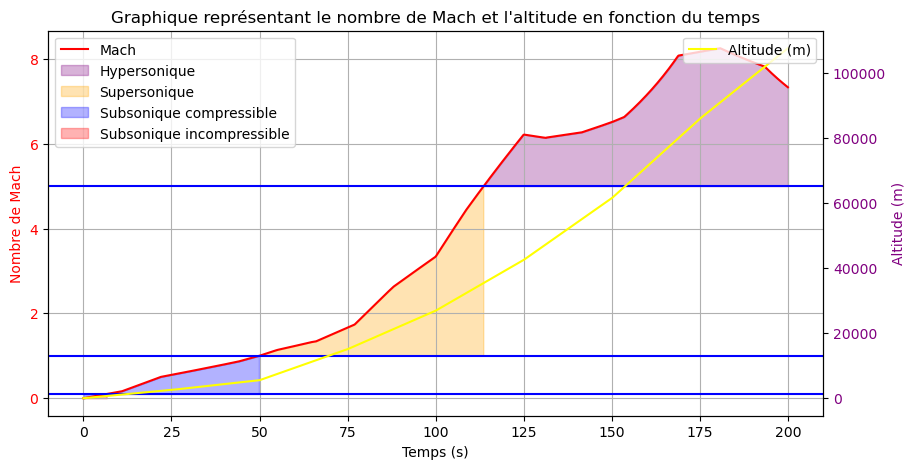

In [2]:
ThermoProperties_dict = Get_ThermoProperties()

Time_array, Mach_array, Altitude_array, P_dyn_array = Get_MachAltitude(ThermoProperties_dict=ThermoProperties_dict)

In [3]:
# --> définition du profil
diameter = 5.45
radius = 0.5*diameter
x_shape = np.linspace(0, 17, 1000)
y_lower_ = -radius * (np.sqrt(x_shape) / np.max(np.sqrt(x_shape)))
y_upper_ = radius * (np.sqrt(x_shape) / np.max(np.sqrt(x_shape)))

# --> Propritétés Thermophysiques
P_inf = 101325
T_inf = 288.15
rho_inf = 1.225
Mach_inf = 10
r_air = np.divide(8.314, 28.966*1e-3)
gamma = 1.4
a_inf = np.sqrt(gamma * r_air * T_inf)
v_inf = Mach_inf * a_inf

AoA = np.deg2rad(0)

inf_cst = {
    'PRESSION': P_inf, 
    'TEMPERATURE': T_inf,
    'MASSE VOLUMIQUE': rho_inf,
    'VITESSE': v_inf
}

In [4]:
# --> Partie inférieur
x_arr, y_lower, dev_angle_lower = AoA_Effect(x_arr=x_shape, y_arr=y_lower_, AoA=AoA)
v_local_lower = Get_Local_Velocity(v_inf=v_inf, EffectiveAngle=dev_angle_lower)

Mach = {
    "MACH_INF": Mach_inf,
    "MACH_LOCAL": v_local_lower / a_inf
}

Velocity = {
    "V_INF": v_inf,
    "V_LOCAL": v_local_lower
}

LocalParams_Lower = Get_Local_Params(inf_cst=inf_cst, Mach=Mach, Velocity=Velocity, deviation_angle=dev_angle_lower, gamma=gamma)

# --> Partie supérieur
x_arr, y_upper, dev_angle_upper = AoA_Effect(x_arr=x_shape, y_arr=y_upper_, AoA=AoA)
v_local_upper = Get_Local_Velocity(v_inf=v_inf, EffectiveAngle=dev_angle_upper)

Mach = {
    "MACH_INF": Mach_inf,
    "MACH_LOCAL": v_local_upper / a_inf
}

Velocity = {
    "V_INF": v_inf,
    "V_LOCAL": v_local_upper
}

LocalParams_Upper = Get_Local_Params(inf_cst=inf_cst, Mach=Mach, Velocity=Velocity, deviation_angle=dev_angle_upper, gamma=gamma)

c:\ProgramData\miniconda3\envs\Elisa5\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique des lanceurs\Projet\src\aero_property\PressureCoeff.py:9: RuntimeWarning: invalid value encountered in sqrt
  beta = np.sqrt(1 - Mach**2)


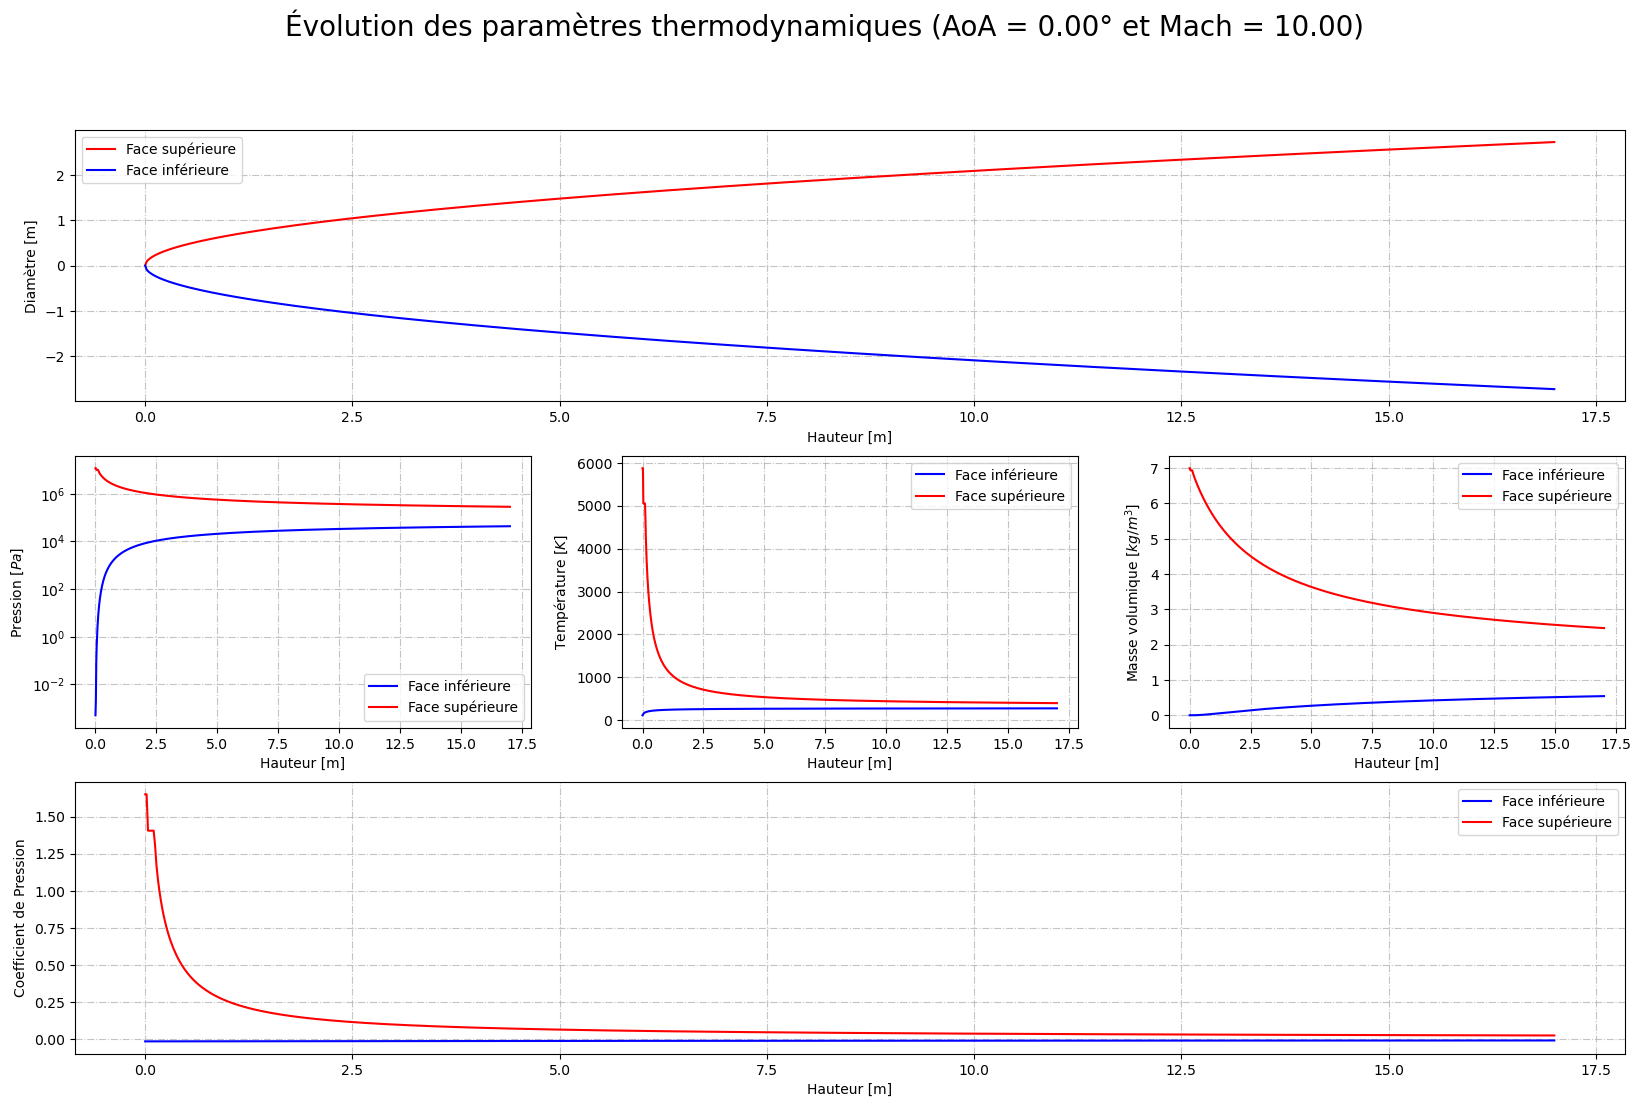

In [5]:
Cp_lower = Get_Pressure_Coeff(Mach=Mach_inf, inf_cst=inf_cst, P=LocalParams_Lower["PRESSION"])
Cp_upper = Get_Pressure_Coeff(Mach=Mach_inf, inf_cst=inf_cst, P=LocalParams_Upper["PRESSION"])

fig = plt.figure(figsize=(20, 12))
fig.suptitle(f"Évolution des paramètres thermodynamiques (AoA = {np.rad2deg(AoA):.2f}° et Mach = {Mach_inf:.2f})", fontsize=20)
gs = GridSpec(3, 3, figure=fig)

profil_ax = fig.add_subplot(gs[0, :])
profil_ax.plot(x_shape, y_upper_, 'r', label='Face supérieure')
profil_ax.plot(x_shape, y_lower_, 'b', label='Face inférieure')

profil_ax.set_xlabel("Hauteur [m]")
profil_ax.set_ylabel("Diamètre [m]")
profil_ax.grid('on', alpha=0.75, linestyle=('-.'))
profil_ax.legend()

axs_0 = fig.add_subplot(gs[1, 0])
axs_0.plot(x_shape, LocalParams_Lower["PRESSION"], 'b', label="Face inférieure")
axs_0.plot(x_shape, LocalParams_Upper["PRESSION"], 'r', label="Face supérieure")
axs_0.set_xlabel('Hauteur [m]')
axs_0.set_ylabel(r'Pression [$Pa$]')
axs_0.grid('on', alpha=0.75, linestyle='-.')
axs_0.set_yscale('log')
axs_0.legend(loc='best')

axs_1 = fig.add_subplot(gs[1, 1])
axs_1.plot(x_shape, LocalParams_Lower["TEMPERATURE"], 'b', label="Face inférieure")
axs_1.plot(x_shape, LocalParams_Upper["TEMPERATURE"], 'r', label="Face supérieure")
axs_1.set_xlabel('Hauteur [m]')
axs_1.set_ylabel(r'Température [$K$]')
axs_1.grid('on', alpha=0.75, linestyle='-.')
axs_1.legend(loc='best')

axs_2 = fig.add_subplot(gs[1, 2])
axs_2.plot(x_shape, LocalParams_Lower["MASSE VOLUMIQUE"], 'b', label="Face inférieure")
axs_2.plot(x_shape, LocalParams_Upper["MASSE VOLUMIQUE"], 'r', label="Face supérieure")
axs_2.set_xlabel('Hauteur [m]')
axs_2.set_ylabel(r'Masse volumique [$kg/m^3$]')
axs_2.grid('on', alpha=0.75, linestyle='-.')
axs_2.legend(loc='best')

pressure_coeff_ax = fig.add_subplot(gs[2, :])
pressure_coeff_ax.plot(x_shape, Cp_lower, 'b', label="Face inférieure")
pressure_coeff_ax.plot(x_shape, Cp_upper, 'r', label="Face supérieure")
pressure_coeff_ax.grid('on', alpha=0.75, linestyle='-.')
pressure_coeff_ax.set_xlabel("Hauteur [m]")
pressure_coeff_ax.set_ylabel("Coefficient de Pression")
pressure_coeff_ax.legend(loc="best")

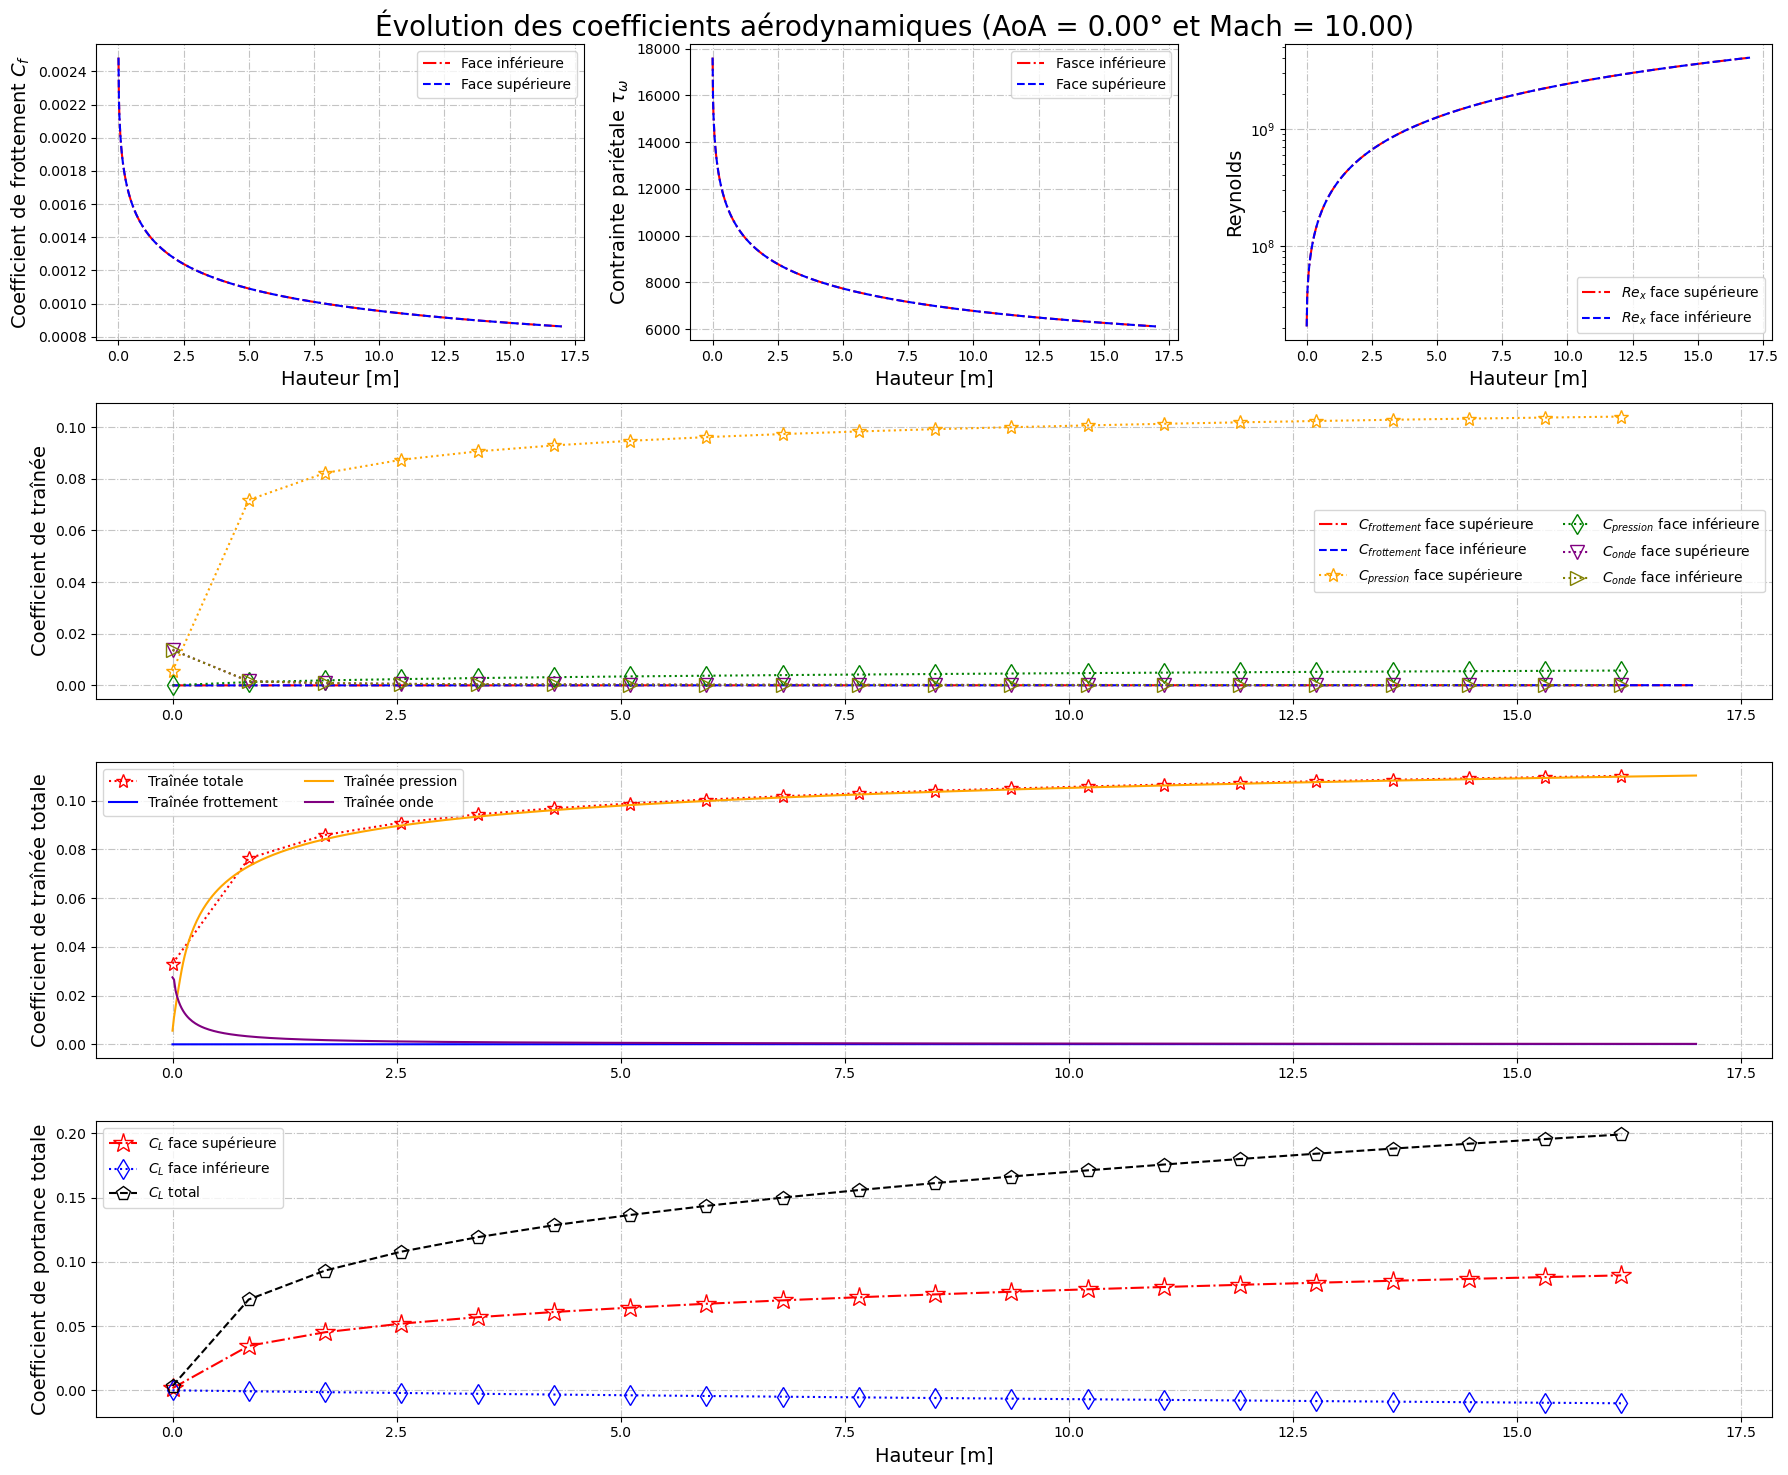

In [6]:
def Sutherland(T):

    return 1.458*1e-6 * ((T**(3/2))/(110.4 + T))

rho = 1.225
v_inf = Mach_inf * np.sqrt(1.4 * 287.07 * 288.15)
mu_inf = Sutherland(T=T_inf)
S_ref = np.pi * diameter * x_shape[-1]

ds_x_upper, s_x_upper = curv(x_arr=x_shape, y_arr=y_upper)
Re_upper = Reynolds(rho=rho_inf, velocity=v_inf, viscosity=mu_inf, s_x=s_x_upper)
Cf_upper = Get_Frot_Coeff(Reynold=Re_upper)
tau_w_upper = Get_Wall_Constraint(Cf=Cf_upper, rho=rho_inf, velocity=v_inf)

Cd_frott_upper, Cd_press_upper, Cd_wave_upper = Get_Drag_Coeff(tau_w=tau_w_upper, Cp=Cp_upper, x_arr=x_shape, y_arr=y_upper, 
                                                               ds_x_arr=ds_x_upper, args=(S_ref, rho_inf, v_inf, Mach_inf, gamma))

ds_x_lower, s_x_lower = curv(x_arr=x_shape, y_arr=y_lower)
Re_lower = Reynolds(rho=rho_inf, velocity=v_inf, viscosity=mu_inf, s_x=s_x_lower)
Cf_lower = Get_Frot_Coeff(Reynold=Re_lower)
tau_w_lower = Get_Wall_Constraint(Cf=Cf_lower, rho=rho_inf, velocity=v_inf)

Cd_frott_lower, Cd_press_lower, Cd_wave_lower = Get_Drag_Coeff(tau_w=tau_w_lower, Cp=Cp_lower, x_arr=x_shape, y_arr=y_lower, 
                                                               ds_x_arr=ds_x_lower, args=(S_ref, rho_inf, v_inf, Mach_inf, gamma))

Cd_frott = {
    "UPP": Cd_frott_upper, 
    "LOW": Cd_frott_lower
}

Cd_press = {
    "UPP": Cd_press_upper, 
    "LOW": Cd_press_lower
} 

Cd_wave = {
    "UPP": Cd_wave_upper, 
    "LOW": Cd_wave_lower
}

Cd_tot, Cd_tot_frott, Cd_tot_pression, Cd_tot_wave = Get_Total_Drag(Cd_frott=Cd_frott, Cd_press=Cd_press, Cd_wave=Cd_wave)

Cp_dict = {
    "UPP": Cp_upper, 
    "LOW": Cp_lower
}

ds_dict = {
    "UPP": ds_x_upper, 
    "LOW": ds_x_lower
}

theta_dict = {
    "UPP": dev_angle_upper, 
    "LOW": dev_angle_lower
}

CL_x, Cl_x_upper, Cl_x_lower = Get_LiftCoeff(Cp_dict=Cp_dict, ds_dict=ds_dict, theta_dict=theta_dict, x_arr=x_shape)


fig = plt.figure(figsize=(18, 15))
fig.suptitle(f"Évolution des coefficients aérodynamiques (AoA = {np.rad2deg(AoA):.2f}° et Mach = {Mach_inf:.2f})", fontsize=20)
gs = GridSpec(4, 3, figure=fig)

merged_ax = fig.add_subplot(gs[1, :])
Drag_ax = fig.add_subplot(gs[2, :], sharex=merged_ax)
Lift_ax = fig.add_subplot(gs[3, :], sharex=merged_ax)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x_shape, Cf_upper, 'r-.', label="Face inférieure")
ax1.plot(x_shape, Cf_lower, 'b--', label="Face supérieure")
ax1.grid('on', alpha=0.75, linestyle='-.')
ax1.set_xlabel("Hauteur [m]", fontsize=14)
ax1.set_ylabel(r"Coefficient de frottement $C_f$", fontsize=14)
ax1.legend(loc="best")

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x_shape, tau_w_upper, 'r-.', label="Fasce inférieure")
ax2.plot(x_shape, tau_w_lower, 'b--', label="Face supérieure")
ax2.grid('on', alpha=0.75, linestyle='-.')
ax2.set_xlabel("Hauteur [m]", fontsize=14)
ax2.set_ylabel(r"Contrainte pariétale $\tau_\omega$", fontsize=14)
ax2.legend(loc="best")

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(x_shape, Re_upper, 'r-.', label=r"$Re_x$ face supérieure")
ax3.plot(x_shape, Re_lower, 'b--', label=r"$Re_x$ face inférieure")
ax3.set_xlabel("Hauteur [m]", fontsize=14)
ax3.set_ylabel("Reynolds", fontsize=14)
ax3.grid('on', alpha=0.75, linestyle='-.')
ax3.set_yscale('log')
ax3.legend()

merged_ax.plot(x_shape, Cd_frott_upper, 'r-.', label=r"$C_{frottement}$ face supérieure")
merged_ax.plot(x_shape, Cd_frott_lower, 'b--', label=r"$C_{frottement}$ face inférieure")

merged_ax.plot(x_shape[::50], Cd_press_upper[::50], c='orange', linestyle=':', marker='*', fillstyle='none', markersize=10, label=r"$C_{pression}$ face supérieure")
merged_ax.plot(x_shape[::50], Cd_press_lower[::50], c='green', linestyle=':', marker='d', fillstyle='none', markersize=10, label=r"$C_{pression}$ face inférieure")

merged_ax.plot(x_shape[::50], Cd_wave_upper[::50], c='purple', linestyle=':', marker='v', fillstyle='none', markersize=10, label=r"$C_{onde}$ face supérieure")
merged_ax.plot(x_shape[::50], Cd_wave_lower[::50], c='olive', linestyle=':', marker='>', fillstyle='none', markersize=10, label=r"$C_{onde}$ face inférieure")

merged_ax.set_ylabel("Coefficient de traînée", fontsize=14)
merged_ax.grid('on', alpha=0.75, linestyle='-.')
merged_ax.legend(loc="best", ncol=2)

Drag_ax.plot(x_shape[::50], Cd_tot[::50], 'r', linestyle=':', marker='*', fillstyle='none', markersize=10, label=r"Traînée totale")
Drag_ax.plot(x_shape, Cd_tot_frott, 'b', label=r"Traînée frottement")
Drag_ax.plot(x_shape, Cd_tot_pression, 'orange', label=r"Traînée pression")
Drag_ax.plot(x_shape, Cd_tot_wave, 'purple', label=r"Traînée onde")
Drag_ax.set_ylabel("Coefficient de traînée totale", fontsize=14)
Drag_ax.grid('on', alpha=0.75, linestyle='-.')
Drag_ax.legend(loc="best", ncol=2)

Lift_ax.plot(x_shape[::50], Cl_x_upper[::50], 'r', linestyle='-.', marker='*', fillstyle='none', markersize=15, label=r"$C_{L}$ face supérieure")
Lift_ax.plot(x_shape[::50], Cl_x_lower[::50], 'b', linestyle=':', marker='d', fillstyle='none', markersize=10, label=r"$C_{L}$ face inférieure")
Lift_ax.plot(x_shape[::50], CL_x[::50], 'k', linestyle='--', marker='p', fillstyle='none', markersize=10, label=r"$C_{L}$ total")
Lift_ax.set_xlabel("Hauteur [m]", fontsize=14)
Lift_ax.set_ylabel("Coefficient de portance totale", fontsize=14)
Lift_ax.grid('on', alpha=0.75, linestyle='-.')
Lift_ax.legend(loc="best")

plt.tight_layout()
plt.show()

Conversion terminée ! Fichier enregistré sous c:\Users\plamb\Desktop\Elisa Aerospace\Elisa 5\Aerodynamique des lanceurs\Projet\src\../docs\CSV_files\ArianeV.csv


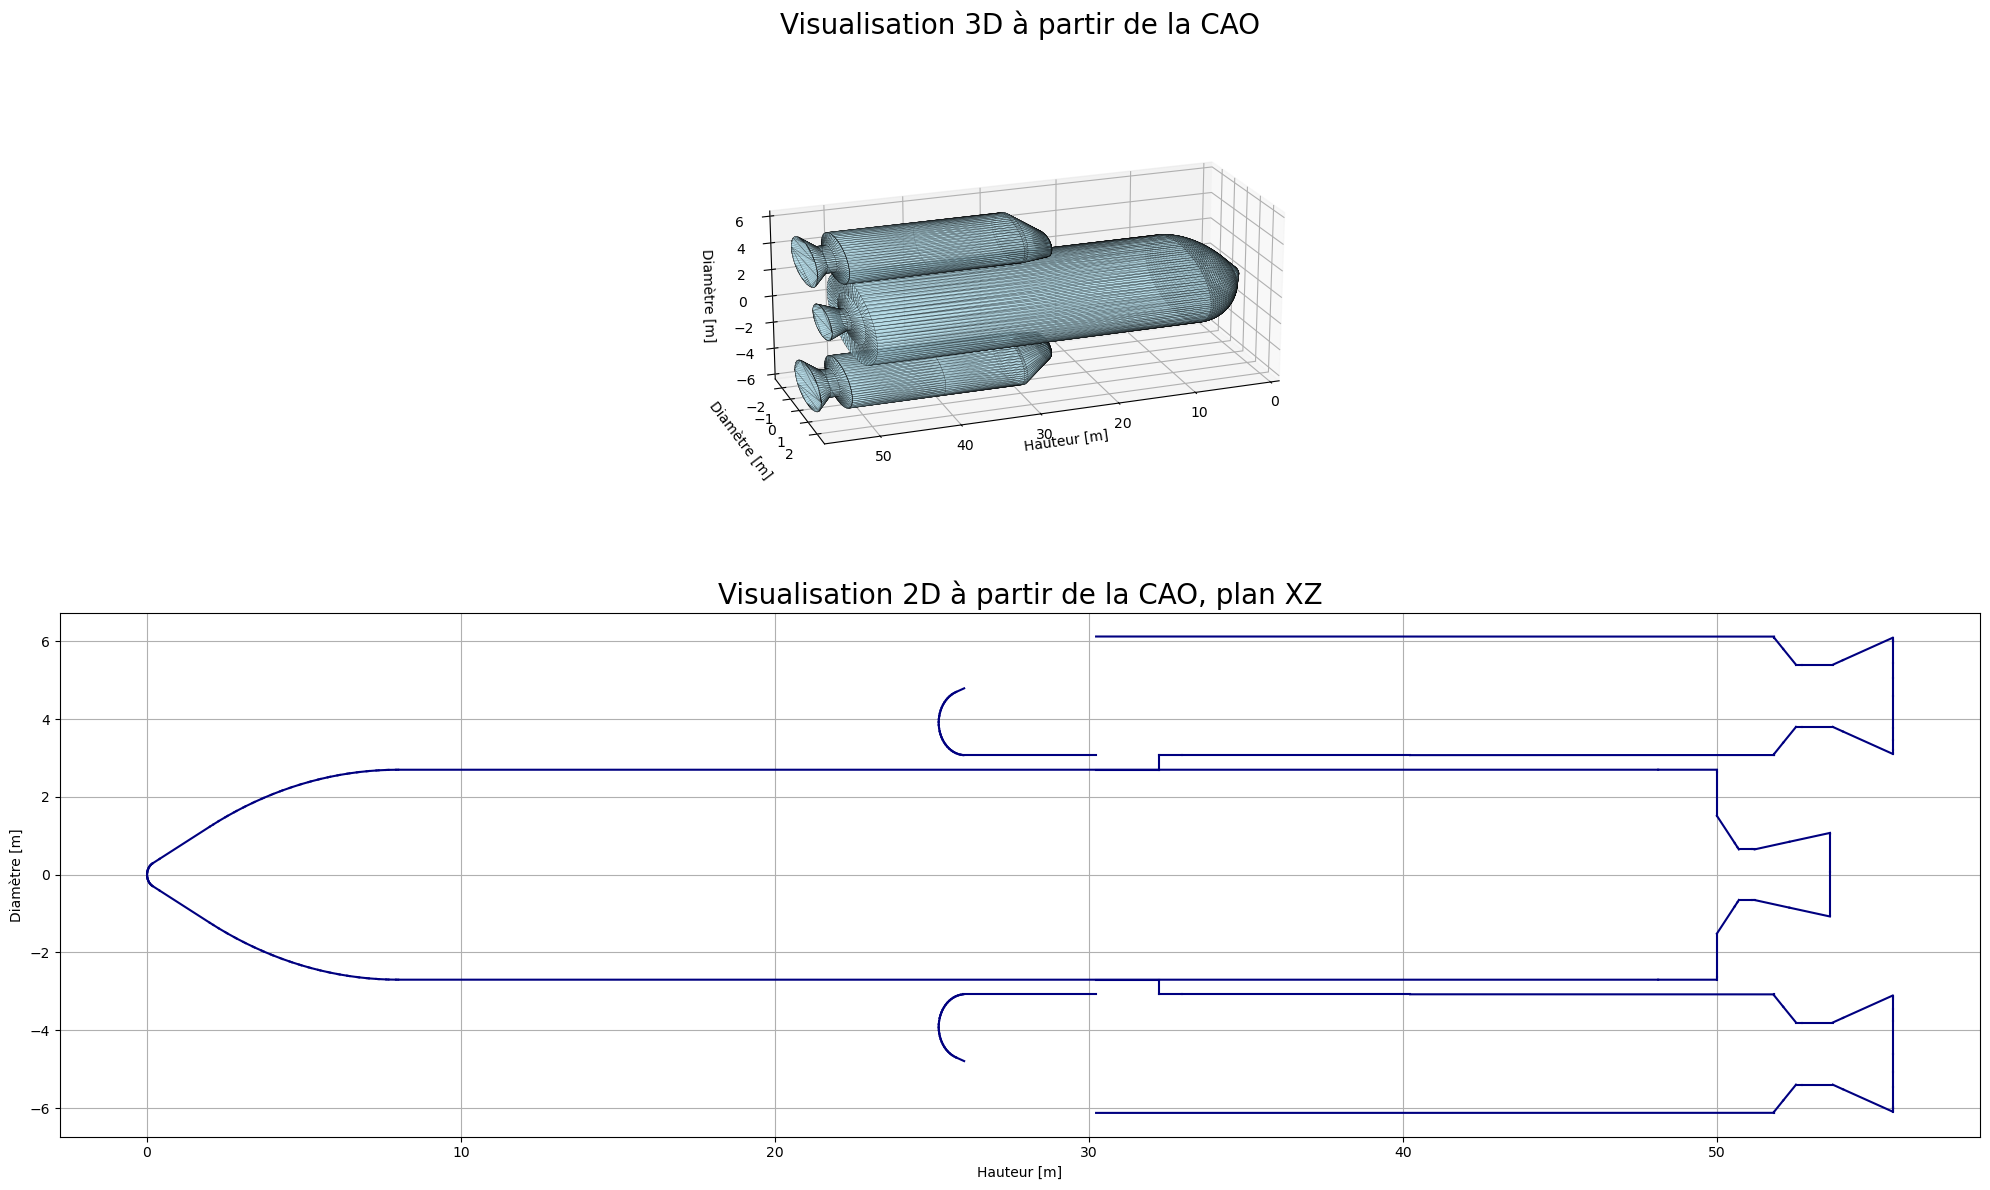

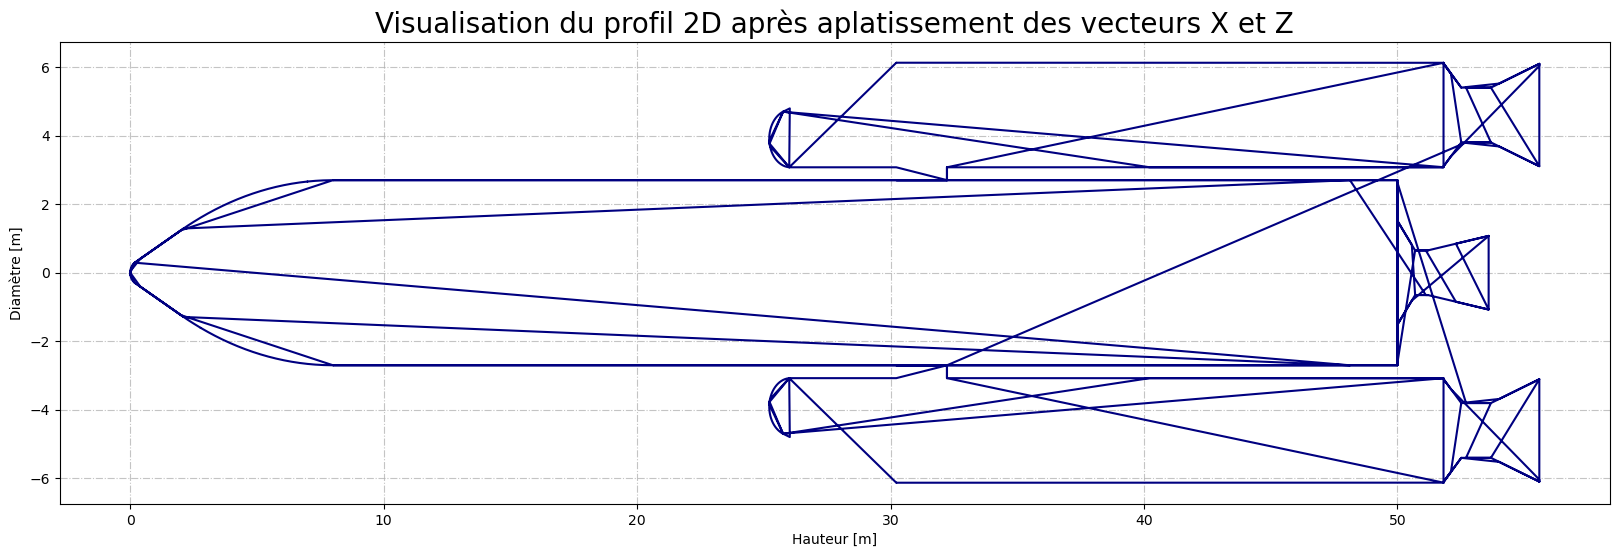

In [7]:
csv_file = Get_CSV(stl_name="ArianeV.stl", csv_name="ArianeV.csv")
triangles_ArianeV, segments_ArianeV = TransformCSV(csv_file=csv_file, Y_FIXE=0.0)

Z_launcher, X_launcher = ShowLaunchersFigure(trianglesLauncher=triangles_ArianeV, segmentsLauncher=segments_ArianeV)

In [8]:
Mach_inf = 0.3

mach_idx = np.argmin(np.abs(Mach_array - Mach_inf))

P_inf_array = ThermoProperties_dict["PRESSION"]
P_inf = P_inf_array[mach_idx]

inf_cst = {key:value[mach_idx] for key, value in ThermoProperties_dict.items()}
print(f"At Mach = {Mach_inf}")
for key, value in inf_cst.items():
    print(f"    -> {key}:   {value}")

At Mach = 0.3
    -> TEMPERATURE:   233.03988988988988
    -> PRESSION:   34313.029264854056
    -> MASSE VOMUMIQUE:   0.4969980054297304
    -> VITESSE DU SON:   306.0130151157452
    -> ALTITUDE_Z:   8478.478478478479
